# EDA and Statistical Analysis

## Imports and Global Settings

In [90]:
import os
import json
import sys
import numpy as np
from dotenv import load_dotenv
import pandas as pd
from pandas.tseries.offsets import Day
from scipy.stats import ttest_ind, ks_2samp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sqlalchemy import create_engine
from ydata_profiling import ProfileReport
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.gridspec as gridspec

here = os.getcwd()
sys.path.append(os.path.join(here, ".."))

from config import NBA_IMPORTANT_DATES, TEAM_MAP
from src.etl.main_etl import ETLPipeline
from src.utils.general_utils import (
    find_season_information,
    determine_season_type,
    add_season_timeframe_info,
)


load_dotenv()
DB_ENDPOINT = os.getenv("DB_ENDPOINT")
DB_PASSWORD = os.getenv("DB_PASSWORD")

# Pandas Settings
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
pd.options.display.max_info_columns = 1000
pd.options.display.precision = 5

# Graphing Settings
sns.set_theme()
sns.set_style()
sns.set_context("notebook")

## Data Loading

### Database Connection

In [2]:
username = "postgres"
password = DB_PASSWORD
endpoint = DB_ENDPOINT
database = "nba_betting"
port = "5432"

# Create the connection string
connection_string = (
    f"postgresql+psycopg2://{username}:{password}@{endpoint}:{port}/{database}"
)

### Loading Games

In [3]:
start_date = "2010-09-01"

features = [
    "game_id",
    "game_datetime",
    "home_team",
    "away_team",
    "open_line",
    "home_score",
    "away_score",
]
games_query = (
    f"SELECT {', '.join(features)} FROM games WHERE game_datetime >= '{start_date}';"
)

with create_engine(connection_string).connect() as connection:
    games = pd.read_sql_query(games_query, connection, parse_dates=["game_datetime"])

### Loading Features

In [119]:
start_date = "2010-09-01"
start_date_int = int(start_date.replace("-", ""))  # Convert date to YYYYMMDD format

features = ["game_id", "data"]

# Extracting the YYYYMMDD portion of the game_id and comparing it with start_date_int
features_query = f"SELECT {', '.join(features)} FROM all_features_json WHERE CAST(LEFT(game_id, 8) AS INTEGER) >= {start_date_int};"

with create_engine(connection_string).connect() as connection:
    all_features = pd.read_sql_query(features_query, connection)

# Normalize the JSON strings in the 'data' column
expanded_data = pd.json_normalize(all_features["data"])

# Drop the original 'data' column and concatenate the expanded data
all_features = pd.concat([all_features.drop(columns=["data"]), expanded_data], axis=1)

0    {'season': '2023-2024', 'away_ATL': 0, 'away_B...
1    {'season': '2023-2024', 'away_ATL': 0, 'away_B...
2    {'season': '2023-2024', 'away_ATL': 0, 'away_B...
3    {'season': '2023-2024', 'away_ATL': 0, 'away_B...
4    {'season': '2023-2024', 'away_ATL': 0, 'away_B...
Name: data, dtype: object
      season  away_ATL  away_BKN  away_BOS  away_CHA  away_CHI  away_CLE  \
0  2023-2024         0         1         0         0         0         0   
1  2023-2024         0         0         0         0         1         0   
2  2023-2024         0         0         1         0         0         0   
3  2023-2024         0         0         0         0         0         0   
4  2023-2024         0         0         0         0         0         0   

   away_DAL  away_DEN  away_DET  away_GSW  away_HOU  away_IND  away_LAC  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0      

### Loading Other Tables

In [5]:
# start_date = "2021-09-01"
# # NBA Stats Team Stats - Traditional
# features = [
#     "team_name",
#     "to_date",
#     "season",
#     "season_type",
#     "games",
#     "w",
#     "l",
#     "w_pct",
#     "plus_minus",
# ]
# team_nbastats_traditional_query = f"SELECT {', '.join(features)} FROM team_nbastats_general_traditional WHERE to_date >= '{start_date}';"

# # 538 Games and Team Stats
# features = [
#     "date",
#     "season",
#     "season_type",
#     "team1",
#     "team2",
#     "elo1_pre",
#     "elo2_pre",
#     "elo_prob1",
#     "elo_prob2",
#     "elo1_post",
#     "elo2_post",
#     "raptor1_pre",
#     "raptor2_pre",
#     "raptor_prob1",
#     "raptor_prob2",
#     "score1",
#     "score2",
# ]
# team_538_query = f"SELECT {', '.join(features)} FROM team_fivethirtyeight_games WHERE date >= '{start_date}'"

# with create_engine(connection_string).connect() as connection:
#     team_nbastats_traditional = pd.read_sql(
#         team_nbastats_traditional_query, connection, parse_dates=["to_date"]
#     )
#     team_538 = pd.read_sql(team_538_query, connection, parse_dates=["date"])

## Working Tables - **Restart From Here**

In [120]:
# Games
games_df = games.copy()

# Features
all_features_df = all_features.copy()

In [7]:
# # Other Tables
# # NBA Stats Team Traditional
# nbastats_team_traditional_df = team_nbastats_traditional.copy()

# # 538 Games and Team Stats
# team_538_df = team_538.copy()

## Data Cleaning and Preprocessing 

In [8]:
def print_table_info(df):
    # Print a sample of the data
    print("\nSample:")
    print(df.sample(10, random_state=42, ignore_index=True))

    # Print the info()
    print("\nInfo:")
    print(df.info(verbose=True, show_counts=True))

In [9]:
for df in [games_df, all_features_df]:
    print_table_info(df)


Sample:
          game_id game_datetime home_team away_team  open_line  home_score  \
0  20190222DALDEN    2019-02-22       DAL       DEN        7.0       104.0   
1  20110330WASMIA    2011-03-30       WAS       MIA       12.5       107.0   
2  20110115CHANOP    2011-01-15       CHA       NOP       -3.5        81.0   
3  20121220DALMIA    2012-12-20       DAL       MIA        5.5        95.0   
4  20220403CLEPHI    2022-04-03       CLE       PHI        5.5       108.0   
5  20180320MINLAC    2018-03-20       MIN       LAC       -3.5       123.0   
6  20170427MILTOR    2017-04-27       MIL       TOR        1.0        89.0   
7  20181121PHINOP    2018-11-21       PHI       NOP       -3.5       121.0   
8  20170110SASMIL    2017-01-10       SAS       MIL      -10.0       107.0   
9  20180322ORLPHI    2018-03-22       ORL       PHI        8.0        98.0   

   away_score  
0       114.0  
1       123.0  
2        88.0  
3       110.0  
4       112.0  
5       109.0  
6        92.0  
7   

### Standardize Team Names

In [10]:
# nbastats_team_traditional_df = ETLPipeline.standardize_team_names(
#     nbastats_team_traditional_df, ["team_name"], TEAM_MAP, print_details=True
# )
# team_538_df = ETLPipeline.standardize_team_names(
#     team_538_df, ["team1", "team2"], TEAM_MAP, print_details=True
# )

### Downcast Data Types

In [11]:
# nbastats_team_traditional_df = ETLPipeline.downcast_data_types(
#     nbastats_team_traditional_df, print_details=True
# )
# team_538_df = ETLPipeline.downcast_data_types(team_538_df, print_details=True)

### Duplicate Records

In [12]:
# nbastats_team_traditional_df = ETLPipeline.check_duplicates(
#     nbastats_team_traditional_df, ["team_name", "to_date", "games"], print_details=True
# )
# team_538_df = ETLPipeline.check_duplicates(
#     team_538_df, ["date", "team1", "team2"], print_details=True
# )

### Pandas Profiling

In [13]:
# games_profile_report = ProfileReport(games_df, title="Games Profiling Report")
# games_profile_report.to_notebook_iframe()

In [14]:
# all_features_profile_report = ProfileReport(
#     all_features_df, title="All Features Profiling Report"
# )
# all_features_profile_report.to_notebook_iframe()

In [15]:
# nbastats_team_traditional_profile_report = ProfileReport(
#     nbastats_team_traditional_df, title="NBAStats Team Traditional Profiling Report"
# )
# nbastats_team_traditional_profile_report.to_notebook_iframe()

In [16]:
# team_538_profile_report = ProfileReport(team_538_df, title="Team 538 Profiling Report")
# team_538_profile_report.to_notebook_iframe()

## Vegas Miss Analysis

In [17]:
games_vegas_analysis_df = games_df.copy()

### Add Season and Date Information
Season, Reg/Post Season, Day of Week, Month, Day of Month, Day of Year, Week of Year

In [18]:
games_vegas_analysis_df = add_season_timeframe_info(games_vegas_analysis_df)

### Optional: Restrict to Regular Season or Postseason Games Only

In [19]:
games_vegas_analysis_df = games_vegas_analysis_df[
    games_vegas_analysis_df["season_type"] == "reg"
]

### Add Targets - Vegas Miss and Vegas Absolute Miss

In [20]:
games_vegas_analysis_df["total_score"] = (
    games_vegas_analysis_df["home_score"] + games_vegas_analysis_df["away_score"]
)
games_vegas_analysis_df["actual_score_diff_hv"] = (
    games_vegas_analysis_df["home_score"] - games_vegas_analysis_df["away_score"]
)
games_vegas_analysis_df["vegas_score_diff_hv"] = -games_vegas_analysis_df["open_line"]
games_vegas_analysis_df["vegas_miss"] = (
    games_vegas_analysis_df["actual_score_diff_hv"]
    - games_vegas_analysis_df["vegas_score_diff_hv"]
)
games_vegas_analysis_df["vegas_miss_zscore"] = (
    games_vegas_analysis_df["vegas_miss"] - games_vegas_analysis_df["vegas_miss"].mean()
) / games_vegas_analysis_df["vegas_miss"].std()
games_vegas_analysis_df["vegas_miss_abs"] = games_vegas_analysis_df["vegas_miss"].abs()
games_vegas_analysis_df["vegas_miss_abs_zscore"] = (
    games_vegas_analysis_df["vegas_miss_abs"]
    - games_vegas_analysis_df["vegas_miss_abs"].mean()
) / games_vegas_analysis_df["vegas_miss_abs"].std()

# A negative vegas_miss means that vegas undervalued the home team and/or overvalued the away team
# A negative vegas_miss also means that the home team outperformed vegas' expectations

### Univariate Analysis for Vegas Miss and Vegas Absolute Miss

In [21]:
def compute_stats(series, print_stats=False, percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    series = pd.Series(series)  # Make sure the input is a pandas Series
    stats = {
        "count": len(series),
        "max": series.max(),
        "min": series.min(),
        "range": series.max() - series.min(),
        "mean": series.mean(),
        "median": series.median(),
        "mode": series.mode()[0] if not series.mode().empty else None,
        "variance": series.var(),
        "std_dev": series.std(),
        "IQR": series.quantile(0.75) - series.quantile(0.25),
        "skewness": series.skew(),
        "kurtosis": series.kurt(),
    }

    # Add percentiles to stats
    for percentile in percentiles:
        key = f"{int(percentile*100)}th_pct"
        stats[key] = series.quantile(percentile)

    if print_stats:
        for key, value in stats.items():
            print(f"{key.capitalize()}: {value}")

    return stats

In [22]:
print("VEGAS MISS STATS")
vegas_miss_stats = compute_stats(
    games_vegas_analysis_df["vegas_miss"], print_stats=True
)
print("\nVEGAS ABSOLUTE MISS STATS")
vegas_abs_miss_stats = compute_stats(
    games_vegas_analysis_df["vegas_miss_abs"], print_stats=True
)

VEGAS MISS STATS
Count: 15396
Max: 62.0
Min: -54.0
Range: 116.0
Mean: -0.15697521961452734
Median: 0.0
Mode: 1.5
Variance: 151.02523259926926
Std_dev: 12.28923238446036
Iqr: 15.5
Skewness: 0.045650607373872824
Kurtosis: 0.46097629524732353
10th_pct: -15.5
25th_pct: -8.0
50th_pct: 0.0
75th_pct: 7.5
90th_pct: 15.5

VEGAS ABSOLUTE MISS STATS
Count: 15396
Max: 62.0
Min: 0.0
Range: 62.0
Mean: 9.579159564704339
Median: 8.0
Mode: 1.5
Variance: 59.28356158300977
Std_dev: 7.699581909624039
Iqr: 10.5
Skewness: 1.2081354137462672
Kurtosis: 1.7542204501140364
10th_pct: 1.5
25th_pct: 3.5
50th_pct: 8.0
75th_pct: 14.0
90th_pct: 20.0


In [91]:
def create_univariate_plots(data, title, x_axis_label):
    # Create a figure
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 5)

    # Boxplot on the left (occupying 1 slot)
    ax1 = fig.add_subplot(gs[0, 0:2])
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title("Boxplot", fontsize=16, fontweight="bold")
    ax1.set_xlabel(x_axis_label)

    # Statistics in the middle (occupying 1 slot)
    ax2 = fig.add_subplot(gs[0, 2:3])
    stats = data.describe()
    mode_val = data.mode().iloc[0]
    iqr = stats["75%"] - stats["25%"]
    stats_text = f'Mean: {stats["mean"]:.2f}\nMedian: {stats["50%"]}\nMode: {mode_val}\nStd Dev: {stats["std"]:.2f}\nMax: {stats["max"]}\nIQR: {iqr}\nQ1: {stats["25%"]}\nQ3: {stats["75%"]}'
    ax2.text(
        0.5,
        0.5,
        stats_text,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=20,
        transform=ax2.transAxes,
    )
    ax2.axis("off")
    ax2.set_title("Statistics", fontsize=16, fontweight="bold")

    # Density plot on the right (occupying 3 slots)
    ax3 = fig.add_subplot(gs[0, 3:])
    sns.histplot(data, ax=ax3, kde=True, binwidth=1)
    ax3.set_title("Density Plot", fontsize=16, fontweight="bold")
    ax3.set_xlabel(x_axis_label)
    ax3.set_ylabel("")  # Removes the y-axis label
    ax3.set_yticks([])  # Removes the y-axis ticks

    # Set main title
    plt.suptitle(title, fontsize=20, fontweight="bold")

    # Show the plot
    plt.tight_layout()
    plt.show()

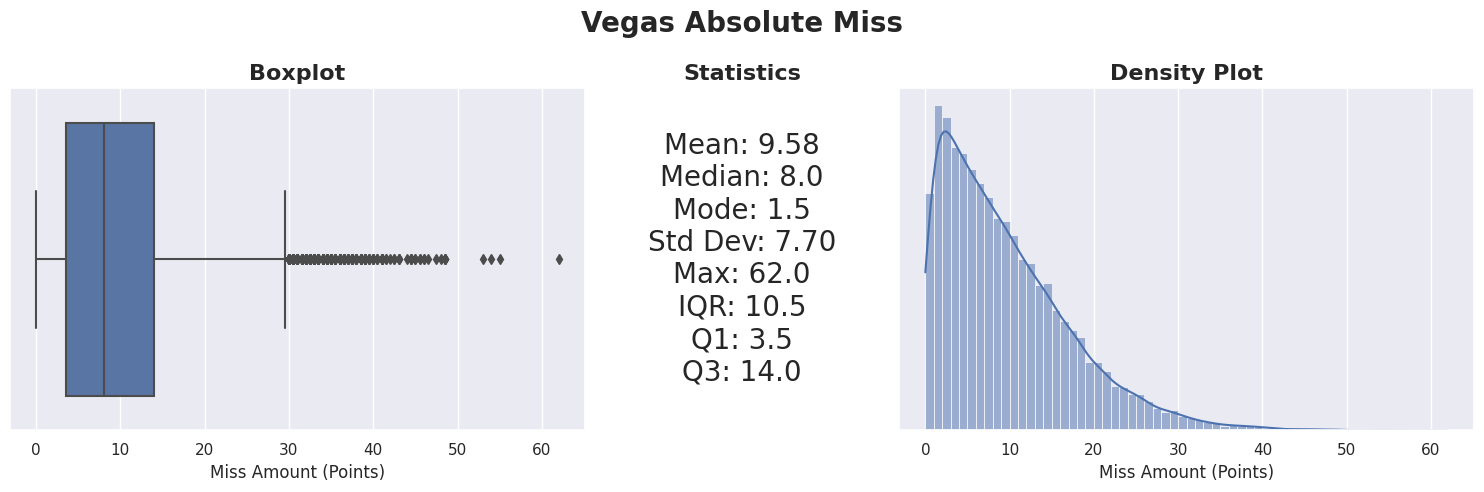

In [92]:
create_univariate_plots(
    games_vegas_analysis_df["vegas_miss_abs"],
    "Vegas Absolute Miss",
    "Miss Amount (Points)",
)

### Main Vegas Miss Graph

In [94]:
def vegas_miss_graph(vegas_miss_abs, season, save=False, image_name=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(
        " Vegas Average Point Spread Error Per Game",
        fontsize=24,
        pad=16,
        fontweight="bold",
    )
    ax.set_xlabel("Season", fontsize=18, labelpad=8, fontweight="bold")
    ax.set_ylabel("Spread Error (Points)", fontsize=18, labelpad=8, fontweight="bold")

    # Create a new DataFrame from the two Series
    df = pd.DataFrame({"vegas_miss_abs": vegas_miss_abs, "season": season})

    # Sort the DataFrame by the 'season' column
    df = df.sort_values("season")

    # Calculate overall mean value
    overall_avg = df["vegas_miss_abs"].mean()

    sns.lineplot(
        x="season", y="vegas_miss_abs", data=df, ax=ax, linewidth=4, errorbar=None
    )

    ax.axhline(overall_avg, color="#C9082A", linestyle="--", linewidth=2)
    ax.text(
        x=df["season"].min(),
        y=overall_avg + 0.05,
        s=f"Overall Average: {overall_avg:.2f}",
        color="#C9082A",
        fontsize=16,
        fontweight="bold",
    )

    # Get the existing x-ticks and labels
    existing_ticks = ax.get_xticks()
    existing_labels = ax.get_xticklabels()

    # Extract the start year from each label and set new x-tick labels
    new_labels = [label.get_text().split("-")[0] for label in existing_labels]
    ax.set_xticklabels(new_labels)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    # plt.legend(fontsize=16)

    if save:
        plt.savefig(f"{image_name}.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_29354/3254670767.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


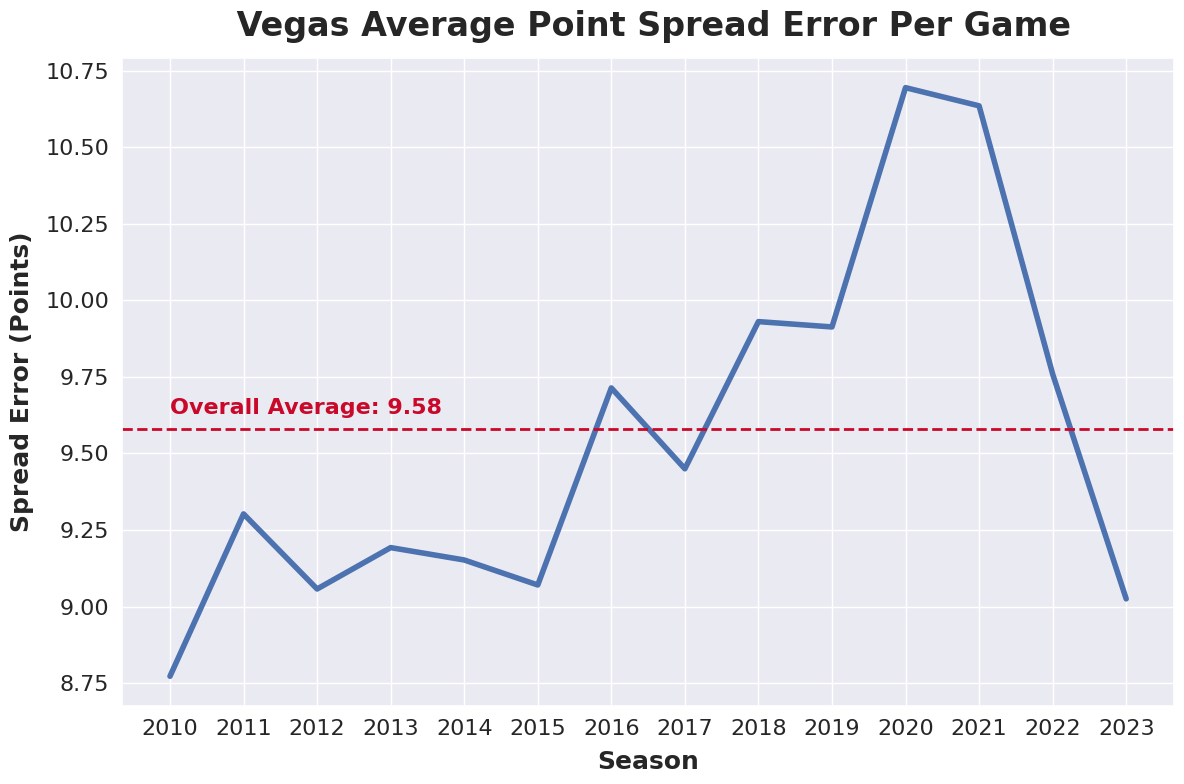

In [95]:
vegas_miss_graph(
    games_vegas_analysis_df["vegas_miss_abs"],
    games_vegas_analysis_df["season"],
    save=False,
    image_name="vegas_miss_abs",
)

### Secondary Vegas Miss Graphs

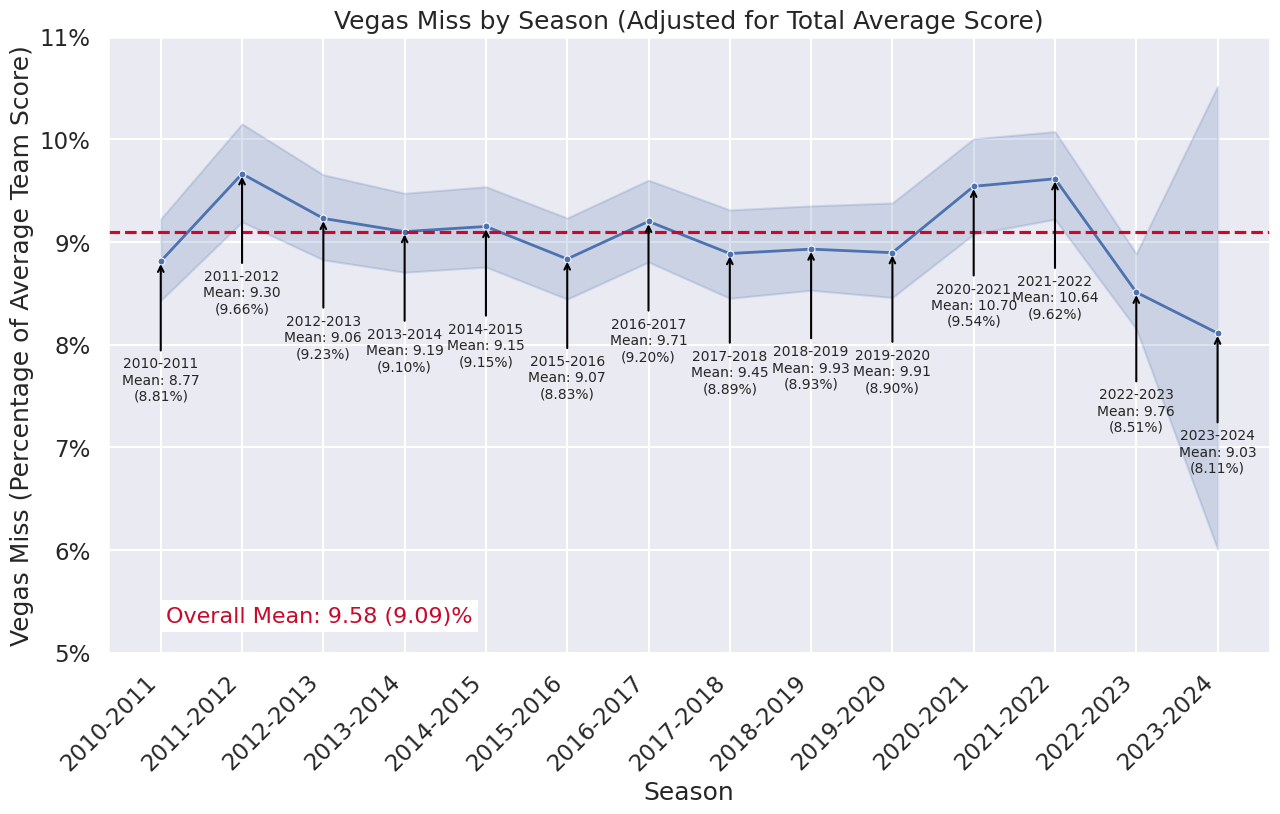

In [99]:
# Sort the DataFrame by the 'season' column
games_vegas_analysis_df = games_vegas_analysis_df.sort_values("season")

# Calculate the total average score for each season
games_vegas_analysis_df["avg_score"] = (
    games_vegas_analysis_df["home_score"] + games_vegas_analysis_df["away_score"]
) / 2
avg_score_by_season = games_vegas_analysis_df.groupby("season")["avg_score"].mean()

# Adjust the "vegas_miss_abs" values by the total average score
games_vegas_analysis_df["adjusted_vegas_miss_abs"] = games_vegas_analysis_df.apply(
    lambda row: row["vegas_miss_abs"] / avg_score_by_season[row["season"]], axis=1
)

# Calculate overall average
overall_mean = games_vegas_analysis_df["vegas_miss_abs"].mean()
overall_mean_pct = games_vegas_analysis_df["adjusted_vegas_miss_abs"].mean()

# Create a line plot
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=games_vegas_analysis_df,
    x="season",
    y="adjusted_vegas_miss_abs",
    marker="o",
    linewidth=2,
    markersize=5,
)

# Add horizontal line showing overall average
plt.axhline(overall_mean_pct, color="#C9082A", linestyle="--")

# Annotate the overall mean
overall_mean_text = f"Overall Mean: {overall_mean:.2f} ({overall_mean_pct*100:.2f})%"
plt.annotate(
    overall_mean_text,
    xy=(0.05, 0.05),
    xycoords="axes fraction",
    backgroundcolor="white",
    fontsize=16,
    color="#C9082A",
)

# Annotating the mean for each week of the season
for season in games_vegas_analysis_df["season"].unique():
    season_mean = games_vegas_analysis_df.loc[
        games_vegas_analysis_df["season"] == season, "adjusted_vegas_miss_abs"
    ].mean()
    season_abs_mean = games_vegas_analysis_df.loc[
        games_vegas_analysis_df["season"] == season, "vegas_miss_abs"
    ].mean()
    plt.annotate(
        f"{season}\nMean: {season_abs_mean:.2f}\n({season_mean*100:.2f}%)",
        (season, season_mean),
        textcoords="offset points",
        xytext=(0, -100),
        ha="center",
        fontsize=10,
        arrowprops=dict(arrowstyle="->", color="black"),
    )

# Set title
plt.title("Vegas Miss by Season (Adjusted for Total Average Score)")
plt.xlabel("Season")
plt.ylabel("Vegas Miss (Percentage of Average Team Score)")
plt.xticks(rotation=45, ha="right")
plt.yticks(
    ticks=plt.yticks()[0], labels=[f"{label*100:.0f}%" for label in plt.yticks()[0]]
)

plt.show()

/tmp/ipykernel_29354/595605065.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


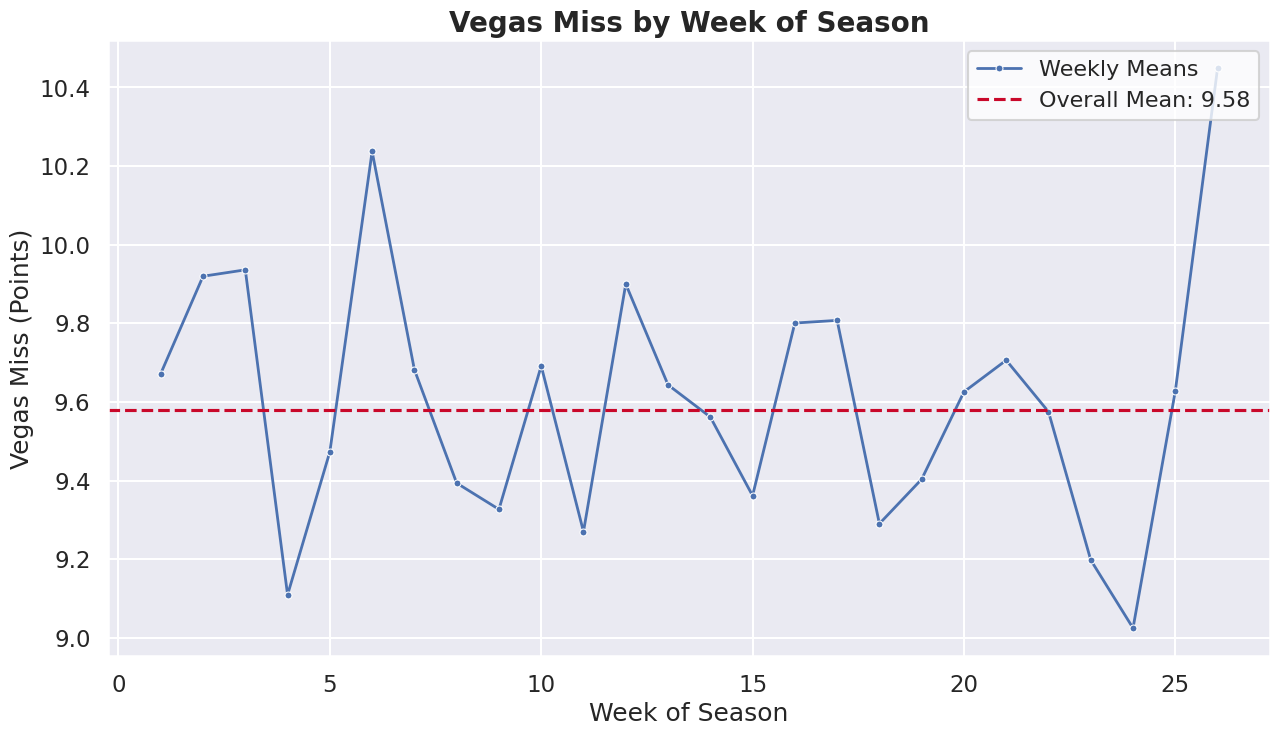

In [98]:
sns.set_style()
sns.set_context("talk")

# Calculate overall average
overall_avg = games_vegas_analysis_df["vegas_miss_abs"].mean()

# Create a line plot
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=games_vegas_analysis_df,
    x="week_of_season",
    y="vegas_miss_abs",
    marker="o",
    linewidth=2,
    markersize=5,
    label="Weekly Means",
    ci=None,
)

# Add horizontal line showing overall average
line = plt.axhline(
    overall_avg,
    color="#C9082A",
    linestyle="--",
    label=f"Overall Mean: {overall_avg:.2f}",
)

plt.legend(loc="upper right", fontsize=16, frameon=True, facecolor="white")


# # Annotating the mean for each week of the season
# for week in games_vegas_analysis_df["week_of_season"].unique():
#     week_mean = games_vegas_analysis_df.loc[
#         games_vegas_analysis_df["week_of_season"] == week, "vegas_miss_abs"
#     ].mean()
#     plt.annotate(
#         f"{week_mean:.2f}",
#         (week, week_mean),
#         textcoords="offset points",
#         xytext=(0, 30),
#         ha="center",
#         fontsize=10,
#         arrowprops=dict(arrowstyle="->", color="black"),
#     )

# Set title
plt.title("Vegas Miss by Week of Season", fontsize=20, fontweight="bold")
plt.xlabel("Week of Season")
plt.ylabel("Vegas Miss (Points)")


plt.show()

### Multivariate Analysis for Vegas Miss and Vegas Absolute Miss

In [100]:
def compare_stats(df, series_name, situations):
    overall_stats = compute_stats(df[series_name])

    result = pd.DataFrame()
    for situation, condition in situations.items():
        subset = df.loc[condition]
        subset_stats = compute_stats(subset[series_name])
        for key, value in subset_stats.items():
            result.at[situation, key] = value
        t_stat, p_value_ttest = ttest_ind(
            df[series_name], subset[series_name], equal_var=False, nan_policy="omit"
        )
        ks_stat, p_value_ks = ks_2samp(
            df[series_name], subset[series_name], alternative="two-sided"
        )
        result.at[situation, "p_value_ttest"] = p_value_ttest
        result.at[situation, "p_value_ks"] = p_value_ks
        result.at[situation, "significant_difference_ttest"] = (
            "Yes" if p_value_ttest < 0.05 else "No"
        )
        result.at[situation, "significant_difference_ks"] = (
            "Yes" if p_value_ks < 0.05 else "No"
        )
        result.at[situation, "difference_in_mean"] = (
            subset[series_name].mean() - df[series_name].mean()
        )

    return result

In [101]:
situations = {
    "Home Team is Favored": games_vegas_analysis_df["vegas_score_diff_hv"] > 0,
    "Away Team is Favored": games_vegas_analysis_df["vegas_score_diff_hv"] < 0,
    "Home team wins ATS": games_vegas_analysis_df["actual_score_diff_hv"]
    > games_vegas_analysis_df["vegas_score_diff_hv"],
    "Away team wins ATS": games_vegas_analysis_df["actual_score_diff_hv"]
    < games_vegas_analysis_df["vegas_score_diff_hv"],
    "Favorite wins ATS": (games_vegas_analysis_df["vegas_score_diff_hv"] > 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        > games_vegas_analysis_df["vegas_score_diff_hv"]
    )
    | (games_vegas_analysis_df["vegas_score_diff_hv"] < 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        < games_vegas_analysis_df["vegas_score_diff_hv"]
    ),
    "Underdog wins ATS": (games_vegas_analysis_df["vegas_score_diff_hv"] > 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        < games_vegas_analysis_df["vegas_score_diff_hv"]
    )
    | (games_vegas_analysis_df["vegas_score_diff_hv"] < 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        > games_vegas_analysis_df["vegas_score_diff_hv"]
    ),
}

for i in range(1, int(max(games_vegas_analysis_df["month_of_season"])) + 1):
    situations[f"Month {i} of season"] = games_vegas_analysis_df["month_of_season"] == i

spread_conditions = [
    (games_vegas_analysis_df["vegas_score_diff_hv"].abs() <= 3, "Within 3 of even"),
    (
        (games_vegas_analysis_df["vegas_score_diff_hv"].abs() > 3)
        & (games_vegas_analysis_df["vegas_score_diff_hv"].abs() <= 5),
        "3-5 of even",
    ),
    (
        (games_vegas_analysis_df["vegas_score_diff_hv"].abs() > 5)
        & (games_vegas_analysis_df["vegas_score_diff_hv"].abs() <= 10),
        "5-10 of even",
    ),
    (games_vegas_analysis_df["vegas_score_diff_hv"].abs() > 10, ">10 from even"),
]

for condition, label in spread_conditions:
    situations[label] = condition

result = compare_stats(games_vegas_analysis_df, "vegas_miss_abs", situations)

In [102]:
result

,count,max,min,range,mean,median,mode,variance,std_dev,IQR,skewness,kurtosis,10th_pct,25th_pct,50th_pct,75th_pct,90th_pct,p_value_ttest,p_value_ks,significant_difference_ttest,significant_difference_ks,difference_in_mean
Home Team is Favored,9916.0,62.0,0.0,62.0,9.51625,7.5,1.5,59.27981,7.69934,10.0,1.22043,1.80768,1.5,3.5,7.5,13.5,20.0,5.26555e-01,5.09861e-01,No,No,-0.06291
Away Team is Favored,5348.0,55.0,0.0,55.0,9.69723,8.0,2.5,59.28067,7.69939,10.5,1.18617,1.66095,1.5,3.5,8.0,14.0,20.5,3.34715e-01,8.80851e-01,No,No,0.11807
Home team wins ATS,7402.0,62.0,0.5,61.5,9.70859,8.0,1.5,59.99972,7.74595,10.5,1.25009,1.87569,1.5,3.5,8.0,14.0,20.5,2.37252e-01,1.14217e-01,No,No,0.12943
Away team wins ATS,7592.0,54.0,0.5,53.5,9.78102,8.0,1.5,57.42369,7.57784,10.0,1.18211,1.68638,1.5,4.0,8.0,14.0,20.5,5.92535e-02,6.59559e-02,No,No,0.20186
Favorite wins ATS,7490.0,62.0,0.5,61.5,9.29226,7.5,2.5,58.01793,7.61695,10.0,1.31305,2.05233,1.5,3.5,7.5,13.5,20.0,7.81985e-03,7.56535e-06,Yes,Yes,-0.28690
Underdog wins ATS,7503.0,55.0,0.5,54.5,10.19852,9.0,1.5,58.96375,7.67879,10.5,1.13240,1.58543,1.5,4.0,9.0,14.5,20.5,1.11804e-08,3.18834e-08,Yes,Yes,0.61936
Month 1 of season,834.0,54.0,0.0,54.0,10.02999,8.0,2.0,67.61276,8.22270,11.0,1.20292,1.64477,1.5,3.5,8.0,14.5,22.0,1.25977e-01,1.01332e-01,No,No,0.45083
Month 2 of season,2912.0,55.0,0.0,55.0,9.64650,8.0,0.5,58.11962,7.62362,10.5,1.13262,1.47920,1.5,3.5,8.0,14.0,20.0,6.64082e-01,6.78826e-01,No,No,0.06734
Month 3 of season,2882.0,62.0,0.0,62.0,9.50894,8.0,1.5,58.52333,7.65005,10.0,1.24115,2.14152,1.5,3.5,8.0,13.5,20.0,6.53119e-01,8.84606e-01,No,No,-0.07022
Month 4 of season,2938.0,48.5,0.0,48.5,9.60642,8.0,1.5,58.60457,7.65536,10.5,1.18576,1.59509,1.5,3.5,8.0,14.0,20.0,8.60346e-01,9.99248e-01,No,No,0.02726


In [103]:
# Compute pairwise correlation of columns
correlation_df = games_vegas_analysis_df.corr(numeric_only=True)

# Select the rows corresponding to the target columns
correlation_df = correlation_df.loc[["vegas_miss", "vegas_miss_abs"]]

In [104]:
correlation_df

,open_line,home_score,away_score,day_of_week,month,month_of_season,week_of_season,total_score,actual_score_diff_hv,vegas_score_diff_hv,vegas_miss,vegas_miss_zscore,vegas_miss_abs,vegas_miss_abs_zscore,avg_score,adjusted_vegas_miss_abs
vegas_miss,0.01694,0.45345,-0.45790,-0.00022,-0.00619,0.00076,0.00168,-0.00562,0.88135,-0.01694,1.00000,1.00000,0.00171,0.00171,-0.00562,0.00146
vegas_miss_abs,0.02120,-0.00033,0.00841,0.00521,-0.00011,-0.01350,-0.01067,0.00474,-0.00850,-0.02120,0.00171,0.00171,1.00000,1.00000,0.00474,0.99610


In [105]:
# games_vegas_analysis_df_report = ProfileReport(
#     games_vegas_analysis_df, title="Game/Bet Profiling Report"
# )
# games_vegas_analysis_df_report.to_notebook_iframe()

## Target Feature Correlations

In [121]:
target_feature_df = all_features_df.copy()

In [122]:
target_feature_df["open_line_hv"] = -target_feature_df["open_line"]

In [123]:
target_feature_df["actual_score_diff_hv"] = (
    target_feature_df["home_score"] - target_feature_df["away_score"]
)

In [124]:
target_feature_df["REG_TARGET"] = target_feature_df["actual_score_diff_hv"]

In [125]:
target_feature_df["CLS_TARGET"] = (
    target_feature_df["actual_score_diff_hv"] > target_feature_df["open_line_hv"]
)  # bet_on_home boolean

In [126]:
target_feature_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16619 entries, 0 to 16618
Data columns (total 765 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    game_id                                       16619 non-null  object 
 1    season                                        16619 non-null  object 
 2    away_ATL                                      16619 non-null  int64  
 3    away_BKN                                      16619 non-null  int64  
 4    away_BOS                                      16619 non-null  int64  
 5    away_CHA                                      16619 non-null  int64  
 6    away_CHI                                      16619 non-null  int64  
 7    away_CLE                                      16619 non-null  int64  
 8    away_DAL                                      16619 non-null  int64  
 9    away_DEN                                      16

In [127]:
# Prep Df

# Drop columns that are not needed
drop_columns = [
    "game_id",
    "home_score",
    "away_score",
    "season",
    "season_type",
    "home_team",
    "away_team",
    "game_datetime",
    "actual_score_diff_hv",
]

target_feature_df = target_feature_df.drop(columns=drop_columns)

In [128]:
target_feature_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16619 entries, 0 to 16618
Data columns (total 756 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    away_ATL                                      16619 non-null  int64  
 1    away_BKN                                      16619 non-null  int64  
 2    away_BOS                                      16619 non-null  int64  
 3    away_CHA                                      16619 non-null  int64  
 4    away_CHI                                      16619 non-null  int64  
 5    away_CLE                                      16619 non-null  int64  
 6    away_DAL                                      16619 non-null  int64  
 7    away_DEN                                      16619 non-null  int64  
 8    away_DET                                      16619 non-null  int64  
 9    away_GSW                                      16

In [129]:
# Drop NA rows
target_feature_df.dropna(inplace=True)

In [130]:
target_feature_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 1500 to 16616
Data columns (total 756 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    away_ATL                                      15117 non-null  int64  
 1    away_BKN                                      15117 non-null  int64  
 2    away_BOS                                      15117 non-null  int64  
 3    away_CHA                                      15117 non-null  int64  
 4    away_CHI                                      15117 non-null  int64  
 5    away_CLE                                      15117 non-null  int64  
 6    away_DAL                                      15117 non-null  int64  
 7    away_DEN                                      15117 non-null  int64  
 8    away_DET                                      15117 non-null  int64  
 9    away_GSW                                     

In [131]:
features = [
    col for col in target_feature_df.columns if col not in ["CLS_TARGET", "REG_TARGET"]
]

# Point-biserial correlation for classification
cls_correlations = (
    target_feature_df[features].corrwith(target_feature_df["CLS_TARGET"]).abs()
)

# Pearson correlation for regression
reg_correlations = (
    target_feature_df[features].corrwith(target_feature_df["REG_TARGET"]).abs()
)

# Mutual Information
mi_classif = mutual_info_classif(
    target_feature_df[features], target_feature_df["CLS_TARGET"]
)
mi_reg = mutual_info_regression(
    target_feature_df[features], target_feature_df["REG_TARGET"]
)

# Feature importance using RandomForest
rf_classif = RandomForestClassifier(n_estimators=50, random_state=1)
rf_classif.fit(target_feature_df[features], target_feature_df["CLS_TARGET"])
classif_importance = rf_classif.feature_importances_

rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
rf_reg.fit(target_feature_df[features], target_feature_df["REG_TARGET"])
reg_importance = rf_reg.feature_importances_

# Combine results into a DataFrame
feature_selection_df = pd.DataFrame(
    {
        "Feature": features,
        "PB Corr CLS": cls_correlations.values,
        "Pearson Corr REG": reg_correlations.values,
        "MI CLS": mi_classif,
        "MI REG": mi_reg,
        "RF FI CLS": classif_importance,
        "RF FI REG": reg_importance,
    }
)

# Round to 2 decimals before ranking
feature_selection_df["PB Corr CLS"] = feature_selection_df["PB Corr CLS"].round(2)
feature_selection_df["Pearson Corr REG"] = feature_selection_df[
    "Pearson Corr REG"
].round(2)
feature_selection_df["MI CLS"] = feature_selection_df["MI CLS"].round(2)
feature_selection_df["MI REG"] = feature_selection_df["MI REG"].round(2)
feature_selection_df["RF FI CLS"] = feature_selection_df["RF FI CLS"].round(2)
feature_selection_df["RF FI REG"] = feature_selection_df["RF FI REG"].round(2)

# Rank features for each metric, using 'max' for tie-breaking
feature_selection_df["Rank PB Corr CLS"] = feature_selection_df["PB Corr CLS"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank Pearson Corr REG"] = feature_selection_df[
    "Pearson Corr REG"
].rank(ascending=False, method="min")
feature_selection_df["Rank MI CLS"] = feature_selection_df["MI CLS"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank MI REG"] = feature_selection_df["MI REG"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank RF FI CLS"] = feature_selection_df["RF FI CLS"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank RF FI REG"] = feature_selection_df["RF FI REG"].rank(
    ascending=False, method="min"
)

# Calculate average rank
feature_selection_df["Average_Rank"] = (
    feature_selection_df.loc[:, "Rank PB Corr CLS":"Rank RF FI REG"]
    .mean(axis=1)
    .round(2)
)

# Sort by average rank
feature_selection_df.sort_values("Average_Rank", inplace=True)

In [132]:
# Create columns for display: rounded metric value (rank)
for metric in [
    "PB Corr CLS",
    "Pearson Corr REG",
    "MI CLS",
    "MI REG",
    "RF FI CLS",
    "RF FI REG",
]:
    feature_selection_df[f"_{metric}"] = (
        feature_selection_df[metric].astype(str)
        + " ("
        + feature_selection_df[f"Rank {metric}"].astype(int).astype(str)
        + ")"
    )

# Columns to display
columns_to_display = [col for col in feature_selection_df.columns if col[0] == "_"]
columns_to_display = ["Feature", "Average_Rank"] + columns_to_display

# Sort by average rank and display the columns
feature_selection_df.sort_values("Average_Rank", inplace=True)
feature_selection_df[columns_to_display]

,Feature,Average_Rank,_PB Corr CLS,_Pearson Corr REG,_MI CLS,_MI REG,_RF FI CLS,_RF FI REG
321,plus_minus_away_all_traditional,13.33,0.02 (10),0.23 (33),0.01 (1),0.03 (32),0.0 (1),0.0 (3)
66,point_diff_hv,20.50,0.01 (112),0.36 (3),0.01 (1),0.08 (3),0.0 (1),0.0 (3)
225,net_rating_away_all_advanced,21.17,0.02 (10),0.23 (33),0.0 (71),0.04 (9),0.0 (1),0.0 (3)
106,home_team_avg_point_diff,22.67,0.01 (112),0.27 (14),0.01 (1),0.05 (5),0.0 (1),0.0 (3)
398,pie_percentile_away_l2w_advanced,23.67,0.02 (10),0.19 (95),0.01 (1),0.03 (32),0.0 (1),0.0 (3)
730,plus_minus_percentile_away_l2w_traditional,23.67,0.02 (10),0.19 (95),0.01 (1),0.03 (32),0.0 (1),0.0 (3)
605,e_net_rating_zscore_away_all_advanced,24.00,0.02 (10),0.24 (27),0.0 (71),0.03 (32),0.0 (1),0.0 (3)
489,net_rating_zscore_away_all_advanced,24.00,0.02 (10),0.24 (27),0.0 (71),0.03 (32),0.0 (1),0.0 (3)
101,away_team_avg_point_diff,25.00,0.02 (10),0.23 (33),0.0 (71),0.03 (32),0.0 (1),0.0 (3)
661,net_rating_percentile_away_all_advanced,25.00,0.02 (10),0.23 (33),0.0 (71),0.03 (32),0.0 (1),0.0 (3)


In [133]:
top_20_features = feature_selection_df[:20]

In [134]:
top_20_features.Feature.to_list()

['plus_minus_away_all_traditional',
 'point_diff_hv',
 'net_rating_away_all_advanced',
 'home_team_avg_point_diff',
 'pie_percentile_away_l2w_advanced',
 'plus_minus_percentile_away_l2w_traditional',
 'e_net_rating_zscore_away_all_advanced',
 'net_rating_zscore_away_all_advanced',
 'away_team_avg_point_diff',
 'net_rating_percentile_away_all_advanced',
 'plus_minus_percentile_away_all_traditional',
 'pie_zscore_away_all_advanced',
 'pie_percentile_away_all_advanced',
 'plus_minus_percentile_away_all_opponent',
 'plus_minus_away_all_opponent',
 'point_diff_last_5_hv',
 'net_rating_zscore_home_l2w_advanced',
 'def_rating_percentile_home_all_advanced',
 'w_zscore_away_all_traditional',
 'w_pct_zscore_away_all_traditional']

## Model Performance Chart

In [141]:
# Re-running the function to include y-tick labels and horizontal grid lines
def plot_model_accuracy_seaborn(
    accuracies, categories, colors, save=False, image_name=None
):
    # Set the Seaborn theme
    sns.set_theme()

    # Initialize the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))

    # Create a DataFrame from the data
    df = pd.DataFrame({"Accuracy": accuracies, "Model": categories})

    # Create the bar chart using Seaborn
    sns.barplot(x="Model", y="Accuracy", data=df, palette=colors, ax=ax)

    # Set the chart title and y-axis label
    ax.set_title(
        "Classification Model Accuracy", fontsize=24, pad=16, fontweight="bold"
    )
    ax.set_ylabel("Accuracy %", fontsize=20, labelpad=8, fontweight="bold")

    # Customize the appearance of the bars
    for index, value in enumerate(accuracies):
        ax.text(
            index,
            value - 5,
            str(value),
            color="white",
            ha="center",
            fontsize=22,
            fontweight="bold",
        )

    # Customize axis tick labels
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Remove x-axis label
    ax.set_xlabel("")

    # Remove all spines
    sns.despine(left=True, bottom=True, right=True, top=True)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color="white")

    plt.tight_layout()

    if save:
        plt.savefig(f"{image_name}.png", dpi=300, bbox_inches="tight")

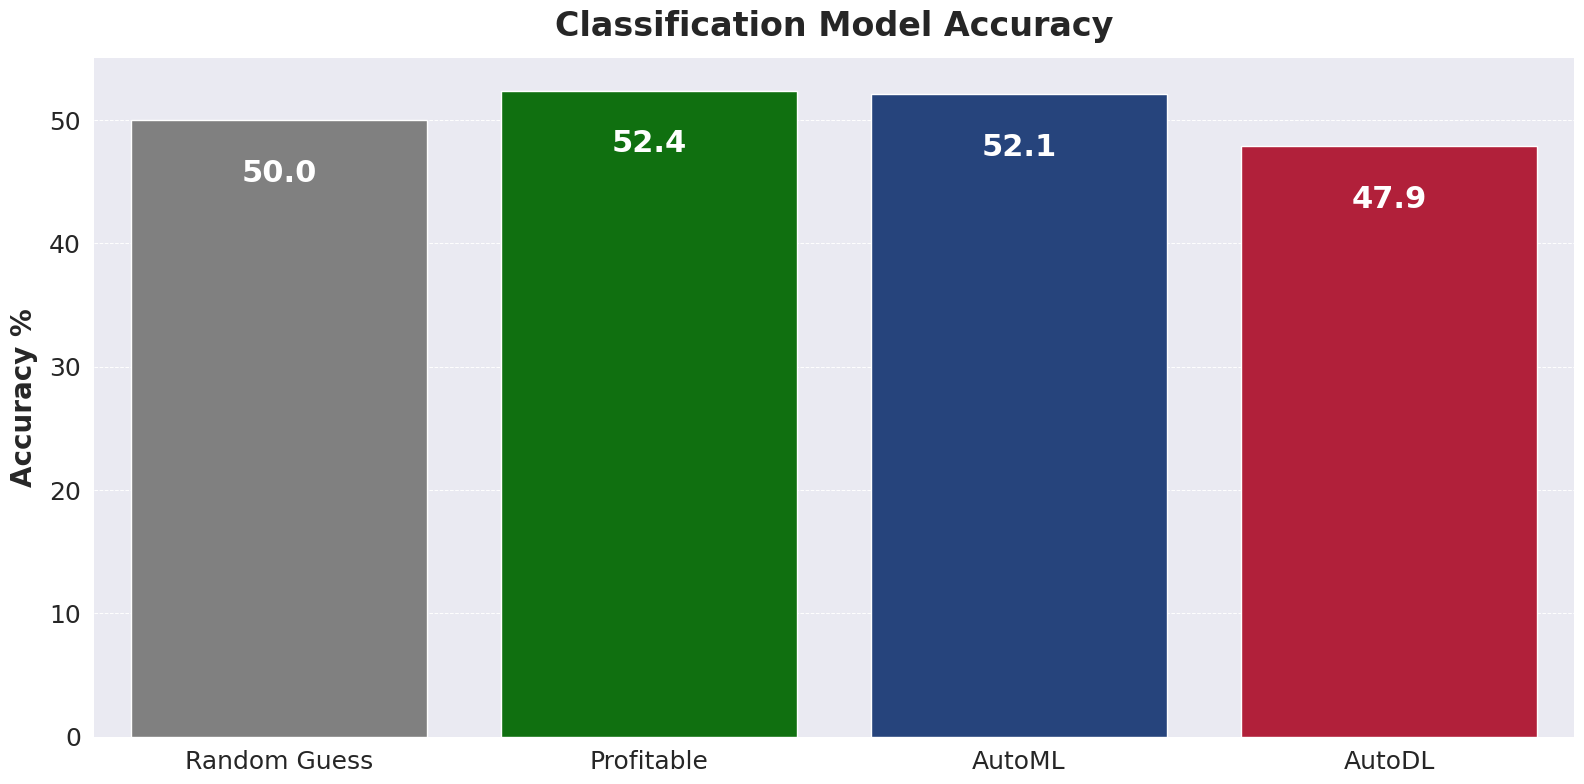

In [142]:
# Example usage with updated specifications
accuracies = [50.0, 52.4, 52.1, 47.9]
categories = ["Random Guess", "Profitable", "AutoML", "AutoDL"]
colors = ["grey", "green", "#17408B", "#C9082A"]

plot_model_accuracy_seaborn(
    accuracies, categories, colors, save=True, image_name="cls_model_accuracy"
)